In [1]:
# Import Dependencies
import lxml
from lxml import html
import requests
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr

In [2]:
# Input
symbol = ['TSLA','AAPL','AMZN','GOOGL']

In [3]:
balance_sheet = {}
financials = {}
cashflows = {}
recent_prices_and_volumes = {}
correlation_matrix = pd.DataFrame()
ratios = {}
dates = []
first_time = 0

# Manual Removal of Headers
bs_column_removal = ['Period Ending',
                     'Current Assets',
                     'Current Liabilities',
                     "Stockholders' Equity"]

fin_column_removal = ['Revenue',
                      'Operating Expenses',
                      'Income from Continuing Operations',
                      "Non-recurring Events",
                      "Net Income"]

cf_column_removal = ['Period Ending',
                     'Operating Activities, Cash Flows Provided By or Used In',
                     'Investing Activities, Cash Flows Provided By or Used In',
                     'Financing Activities, Cash Flows Provided By or Used In']

for s in symbol:
    recent_prices_and_volumes[s,'Close'] = []
    recent_prices_and_volumes[s,'Volume'] = []
    balance_sheet_url = 'https://finance.yahoo.com/quote/' + s + '/balance-sheet?p=' + s
    financials_url = 'https://finance.yahoo.com/quote/' + s + '/financials?p=' + s
    cashflows_url = 'https://finance.yahoo.com/quote/' + s + '/cash-flow?p=' + s
    
    # Balance Sheet
    page = requests.get(balance_sheet_url)
    tree = html.fromstring(page.content)
    table = tree.xpath('//table')
    assert len(table) == 1
    
    if first_time == 0:
        balance_sheet[s] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()
        balance_sheet_columns = balance_sheet[s].columns
        index = balance_sheet[s][balance_sheet[s].columns[0]].values
        first_time = 1
        del balance_sheet[s]
        
        for y in index:
            dates.append(y[-4:])
    
    for c in balance_sheet_columns:
        balance_sheet[s, c] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()[c]
        
    for r in bs_column_removal:
         del balance_sheet[s,r]
                
    # Financials / Income Statement
    page = requests.get(financials_url)
    tree = html.fromstring(page.content)
    table = tree.xpath('//table')
    assert len(table) == 1
    
    if first_time == 1:
        financials[s] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()
        financials_columns = financials[s].columns
        first_time = 2
        del financials[s]
    
    for c in financials_columns:
        financials[s, c] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()[c]
        
    for r in fin_column_removal:
         del financials[s,r]
    
    # Cashflows
    page = requests.get(cashflows_url)
    tree = html.fromstring(page.content)
    table = tree.xpath('//table')
    assert len(table) == 1
    
    if first_time == 2:
        cashflows[s] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()
        cashflows_columns = cashflows[s].columns
        first_time = 3
        del cashflows[s]
    
    for c in cashflows_columns:
        cashflows[s, c] = pd.read_html(lxml.etree.tostring(table[0], method='html'))[0].set_index(0).transpose()[c]
        
    for r in cf_column_removal:
         del cashflows[s,r]
    
    if first_time == 3:
        # Download Stock Data
        stock_data = pdr.DataReader(symbol, 'yahoo', dates[-1], int(dates[0])+1)

        # Swap Levels to Match BS/Fin/CF structure
        stock_data = stock_data.swaplevel(0,1, axis=1)

        first_time = 4
    
    stock_data[s,'Return'] = stock_data[s,'Adj Close'].pct_change(1).dropna().round(4)
    correlation_matrix[s] = stock_data[s,'Return']

    for d in dates:
        close = stock_data[s,'Close'].filter(like=d, axis=0)[-1:][0]
        volume = stock_data[s,'Volume'].filter(like=d, axis=0)[-1:][0]
        
        recent_prices_and_volumes[s, 'Close'].append(close)
        recent_prices_and_volumes[s, 'Volume'].append(volume)

stock_data = stock_data.reindex(sorted(stock_data.columns), axis=1)[1:]
correlation_matrix = round(correlation_matrix.corr(), 2)

# Convert to DataFrames
balance_sheet = pd.DataFrame(balance_sheet).set_index(index)
financials = pd.DataFrame(financials).set_index(index)
cashflows = pd.DataFrame(cashflows).set_index(index)
recent_prices_and_volumes = pd.DataFrame(recent_prices_and_volumes, index=index)
        
# Replace - with a 0 to be able to convert everything to integers
balance_sheet = abs(balance_sheet.replace('-','0').astype(int))
financials = abs(financials.replace('-','0').astype(int))
cashflows = abs(cashflows.replace('-','0').astype(int))
        
# Ratio Analysis
for s in symbol:
    ratios[s, 'Current Ratio'] = balance_sheet[s,'Total Current Assets'] / balance_sheet[s,'Total Current Liabilities']
    ratios[s, 'Quick Ratio'] = (balance_sheet[s,'Total Current Assets'] - balance_sheet[s,'Inventory']) / balance_sheet[s,'Total Current Liabilities']
    ratios[s, 'Debt Ratio'] = (balance_sheet[s,'Total Assets'] - balance_sheet[s,'Total Stockholder Equity']) / balance_sheet[s,'Total Assets'] 
    ratios[s, 'DE Ratio'] = (balance_sheet[s,'Total Assets'] - balance_sheet[s,'Total Stockholder Equity']) / balance_sheet[s,'Total Stockholder Equity']
    ratios[s, 'Receiv Turnover'] = financials[s,'Total Revenue'] / balance_sheet[s,'Net Receivables']
    ratios[s, 'Inv Turnover'] = financials[s,'Cost of Revenue'] / balance_sheet[s,'Inventory']
    ratios[s, 'Profit Margin'] = financials[s,'Net Income From Continuing Ops'] / financials[s,'Total Revenue']
    ratios[s, 'ROA'] = financials[s,'Net Income From Continuing Ops'] / balance_sheet[s,'Total Assets']
    ratios[s, 'ROE'] = financials[s,'Net Income From Continuing Ops'] / balance_sheet[s,'Total Stockholder Equity']
    ratios[s, 'Earnings per Share'] = financials[s,'Net Income From Continuing Ops'] / recent_prices_and_volumes[s,'Volume']
    ratios[s, 'P/E Ratio'] = recent_prices_and_volumes[s,'Close'] / ratios[s, 'Earnings per Share']
            
# Convert to DataFrame
ratios = pd.DataFrame(ratios).round(2)

In [4]:
# Show Data
print('Balance Sheet')
display(balance_sheet)
print('Income Statement')
display(financials)
print('Cashflow')
display(cashflows)
print('Stock Data')
display(stock_data.head())
print('End of the Year Stock Prices and Volumes')
display(recent_prices_and_volumes)
print('Ratios')
display(ratios)
print('Correlations')
display(correlation_matrix)

Balance Sheet


TSLA                                         \
           Cash And Cash Equivalents Short Term Investments Net Receivables   
12/31/2018                   3685618                      0          949022   
12/31/2017                   3367914                      0          515381   
12/31/2016                   3393216                      0          499142   
12/31/2015                   1196908                      0          168965   

                                                                \
           Inventory Other Current Assets Total Current Assets   
12/31/2018   3113446               192551              8306308   
12/31/2017   2263537               155323              6570520   
12/31/2016   2067454               105519              6259796   
12/31/2015   1277838                29928              2782006   

                                                                        \
           Long Term Investments Property Plant and Equipment Goodwill   
12/31/2018                 12159                     19691231    68159   
12/31/2017                  5304                     20491616    60237   
12/31/2016                     0                     15036917        0   
12/31/2015                     0                      5194737        0   

                              ...                         GOOGL  \
           Intangible Assets  ... Misc. Stocks Options Warrants   
12/31/2018            282492  ...                             0   
12/31/2017            361502  ...                             0   
12/31/2016            376145  ...                             0   
12/31/2015             12816  ...                             0   

                                                                    \
           Redeemable Preferred Stock Preferred Stock Common Stock   
12/31/2018                          0               0     45049000   
12/31/2017                          0               0     40247000   
12/31/2016                          0               0     36307000   
12/31/2015                          0               0     32982000   

                                                             \
           Retained Earnings Treasury Stock Capital Surplus   
12/31/2018         134885000        2306000               0   
12/31/2017         113247000         992000               0   
12/31/2016         105131000        2402000               0   
12/31/2015          89223000        1874000               0   

                                                              \
           Other Stockholder Equity Total Stockholder Equity   
12/31/2018                  2306000                177628000   
12/31/2017                   992000                152502000   
12/31/2016                  2402000                139036000   
12/31/2015                  1874000                120331000   

                                
           Net Tangible Assets  
12/31/2018           157520000  
12/31/2017           133063000  
12/31/2016           119261000  
12/31/2015           100615000  

[4 rows x 136 columns]

Income Statement


TSLA                                                    \
           Total Revenue Cost of Revenue Gross Profit Research Development   
12/31/2018      21461268        17419247      4042021              1460370   
12/31/2017      11758751         9536264      2222487              1378073   
12/31/2016       7000132         5400875      1599257               834408   
12/31/2015       4046025         3122522       923503               717900   

                                                                    \
           Selling General and Administrative Non Recurring Others   
12/31/2018                            2834491             0      0   
12/31/2017                            2450700             0      0   
12/31/2016                            1410489             0      0   
12/31/2015                             922232             0      0   

                                                              \
           Total Operating Expenses Operating Income or Loss   
12/31/2018                 21714108                   252840   
12/31/2017                 13365037                  1606286   
12/31/2016                  7645772                   645640   
12/31/2015                  4762654                   716629   

                                            ...             GOOGL  \
           Total Other Income/Expenses Net  ... Income Before Tax   
12/31/2018                          751905  ...          34913000   
12/31/2017                          602746  ...          27193000   
12/31/2016                          100708  ...          24150000   
12/31/2015                          158995  ...          19651000   

                                                 \
           Income Tax Expense Minority Interest   
12/31/2018            4177000                 0   
12/31/2017           14531000                 0   
12/31/2016            4672000                 0   
12/31/2015            3303000                 0   

                                                                   \
           Net Income From Continuing Ops Discontinued Operations   
12/31/2018                       30736000                       0   
12/31/2017                       12662000                       0   
12/31/2016                       19478000                       0   
12/31/2015                       16348000                       0   

                                                                         \
           Extraordinary Items Effect Of Accounting Changes Other Items   
12/31/2018                   0                            0           0   
12/31/2017                   0                            0           0   
12/31/2016                   0                            0           0   
12/31/2015                   0                            0           0   

                                                  \
           Preferred Stock And Other Adjustments   
12/31/2018                                     0   
12/31/2017                                     0   
12/31/2016                                     0   
12/31/2015                                     0   

                                                   
           Net Income Applicable To Common Shares  
12/31/2018                               30736000  
12/31/2017                               12662000  
12/31/2016                               19478000  
12/31/2015                               16348000  

[4 rows x 88 columns]

Cashflow


TSLA                                         \
           Net Income Depreciation Adjustments To Net Income   
12/31/2018     976091      1887750                    969462   
12/31/2017    1961400      1636003                    670309   
12/31/2016     674914       947099                    203157   
12/31/2015     888663       422590                    356809   

                                                                   \
           Changes In Accounts Receivables Changes In Liabilities   
12/31/2018                          496732                2129511   
12/31/2017                           24635                 857108   
12/31/2016                          216565                1133602   
12/31/2015                           46267                 585548   

                                                                         \
           Changes In Inventories Changes In Other Operating Activities   
12/31/2018                1023264                                551564   
12/31/2017                 178850                               1150226   
12/31/2016                 632867                                978031   
12/31/2015                 369364                                755740   

                                                                           \
           Total Cash Flow From Operating Activities Capital Expenditures   
12/31/2018                                   2097802              2319516   
12/31/2017                                     60654              4081354   
12/31/2016                                    123829              1440471   
12/31/2015                                    524499              1634850   

                        ...       GOOGL  \
           Investments  ... Investments   
12/31/2018           0  ...     1972000   
12/31/2017           0  ...    19448000   
12/31/2016       16667  ...    18229000   
12/31/2015       16667  ...    13635000   

                                                       \
           Other Cash flows from Investing Activities   
12/31/2018                                          0   
12/31/2017                                    1419000   
12/31/2016                                    1978000   
12/31/2015                                      75000   

                                                                      \
           Total Cash Flows From Investing Activities Dividends Paid   
12/31/2018                                   28504000              0   
12/31/2017                                   31401000              0   
12/31/2016                                   31165000              0   
12/31/2015                                   23711000              0   

                                                  \
           Sale Purchase of Stock Net Borrowings   
12/31/2018                      0          61000   
12/31/2017                      0          86000   
12/31/2016                      0        1335000   
12/31/2015                      0          23000   

                                                       \
           Other Cash Flows from Financing Activities   
12/31/2018                                    4043000   
12/31/2017                                    3366000   
12/31/2016                                    3304000   
12/31/2015                                    2422000   

                                                       \
           Total Cash Flows From Financing Activities   
12/31/2018                                   13179000   
12/31/2017                                    8298000   
12/31/2016                                    8332000   
12/31/2015                                    4225000   

                                                                                
           Effect Of Exchange Rate Changes Change In Cash and Cash Equivalents  
12/31/2018                          302000                             5986000  
12/31/2017                

Stock Data


Symbols           AAPL                                                  \
Attributes   Adj Close       Close        High         Low        Open   
Date                                                                     
2015-01-05   98.667984  106.250000  108.650002  105.410004  108.290001   
2015-01-06   98.677261  106.260002  107.430000  104.629997  106.540001   
2015-01-07  100.060936  107.750000  108.199997  106.699997  107.199997   
2015-01-08  103.905510  111.889999  112.150002  108.699997  109.230003   
2015-01-09  104.016945  112.010002  113.250000  110.209999  112.669998   

Symbols                               AMZN                          ...  \
Attributes  Return      Volume   Adj Close       Close        High  ...   
Date                                                                ...   
2015-01-05 -0.0282  64285500.0  302.190002  302.190002  308.380005  ...   
2015-01-06  0.0001  65797100.0  295.290009  295.290009  303.000000  ...   
2015-01-07  0.0140  40105900.0  298.420013  298.420013  301.279999  ...   
2015-01-08  0.0384  59364500.0  300.459991  300.459991  303.140015  ...   
2015-01-09  0.0011  53699500.0  296.929993  296.929993  302.869995  ...   

Symbols          GOOGL                           TSLA                          \
Attributes        Open  Return     Volume   Adj Close       Close        High   
Date                                                                            
2015-01-05  527.150024 -0.0191  2059100.0  210.089996  210.089996  216.500000   
2015-01-06  520.500000 -0.0247  2722800.0  211.279999  211.279999  214.199997   
2015-01-07  510.950012 -0.0029  2345900.0  210.949997  210.949997  214.779999   
2015-01-08  501.510010  0.0035  3652700.0  210.619995  210.619995  213.800003   
2015-01-09  508.179993 -0.0122  2097000.0  206.660004  206.660004  209.979996   

Symbols                                                
Attributes         Low        Open  Return     Volume  
Date                                                   
2015-01-05  207.160004  214.550003 -0.0420  5368500.0  
2015-01-06  204.210007  210.059998  0.0057  6261900.0  
2015-01-07  209.779999  213.350006 -0.0016  2968400.0  
2015-01-08  210.009995  212.809998 -0.0016  3442500.0  
2015-01-09  204.960007  208.919998 -0.0188  4591300.0  

[5 rows x 28 columns]

End of the Year Stock Prices and Volumes


TSLA                   AAPL                     AMZN  \
                 Close     Volume       Close      Volume        Close   
12/31/2018  332.799988  6302300.0  157.740005  35003500.0  1501.969971   
12/31/2017  311.350006  3777200.0  169.229996  25884400.0  1169.469971   
12/31/2016  213.690002  4642600.0  115.820000  30586300.0   749.869995   
12/31/2015  240.009995  2715000.0  105.260002  40635300.0   675.890015   

                             GOOGL             
               Volume        Close     Volume  
12/31/2018  6954500.0  1044.959961  1655500.0  
12/31/2017  2688400.0  1053.400024  1180300.0  
12/31/2016  4139400.0   792.450012  1735900.0  
12/31/2015  3749600.0   778.010010  1637600.0

Ratios


TSLA                                                  \
           Current Ratio Quick Ratio Debt Ratio DE Ratio Receiv Turnover   
12/31/2018          0.83        0.52       0.83     5.04           22.61   
12/31/2017          0.86        0.56       0.85     5.76           22.82   
12/31/2016          1.07        0.72       0.79     3.77           14.02   
12/31/2015          0.97        0.53       0.87     6.44           23.95   

                                                                      ...  \
           Inv Turnover Profit Margin   ROA   ROE Earnings per Share  ...   
12/31/2018         5.59          0.05  0.04  0.22               0.17  ...   
12/31/2017         4.21          0.19  0.08  0.53               0.59  ...   
12/31/2016         2.61          0.11  0.03  0.16               0.17  ...   
12/31/2015         2.44          0.22  0.11  0.82               0.33  ...   

                 GOOGL                                                   \
           Quick Ratio Debt Ratio DE Ratio Receiv Turnover Inv Turnover   
12/31/2018        3.89       0.24     0.31            6.46        53.79   
12/31/2017        5.11       0.23     0.29            5.93        60.86   
12/31/2016        6.27       0.17     0.20            5.77       131.11   
12/31/2015        4.64       0.18     0.23            5.57        57.36   

                                                                   
           Profit Margin   ROA   ROE Earnings per Share P/E Ratio  
12/31/2018          0.22  0.13  0.17              18.57     56.28  
12/31/2017          0.11  0.06  0.08              10.73     98.19  
12/31/2016          0.22  0.12  0.14              11.22     70.62  
12/31/2015          0.22  0.11  0.14               9.98     77.93  

[4 rows x 44 columns]

Correlations


,TSLA,AAPL,AMZN,GOOGL
TSLA,1.00,0.29,0.32,0.31
AAPL,0.29,1.00,0.48,0.51
AMZN,0.32,0.48,1.00,0.65
GOOGL,0.31,0.51,0.65,1.00


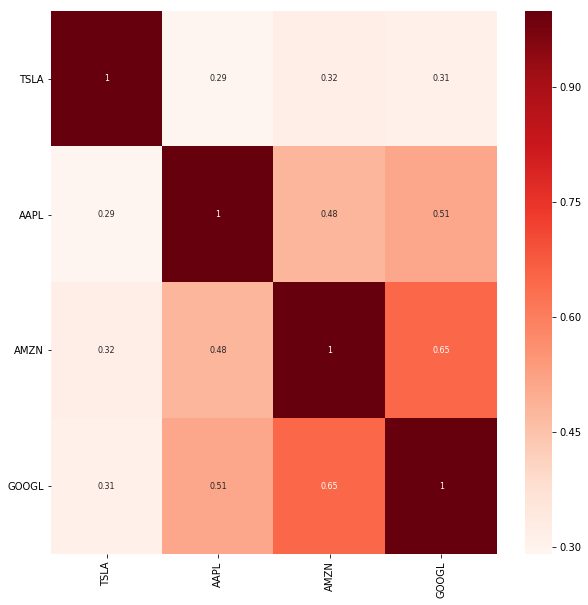

In [5]:
# Plot a Correlation Graph
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix,
        annot = True,
        cmap = "Reds",
        annot_kws = {'size':8})

plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

In [6]:
# Write to Excel
for s in symbol:
    writer = pd.ExcelWriter('Fundamental Analysis ' + s + '.xlsx', engine='xlsxwriter')
    
    balance_sheet[s].transpose().to_excel(writer, sheet_name='Balance Sheet')
    financials[s].transpose().to_excel(writer, sheet_name='Income Statement')
    cashflows[s].transpose().to_excel(writer, sheet_name='Cashflows')
    stock_data[s].to_excel(writer, sheet_name='Stock Data')
    ratios[s].transpose().to_excel(writer, sheet_name='Ratio Analysis')
    
    writer.save() 